# __All-in-One:Emotion, Sentiment and Intensity Prediction using a Multi-task Ensemble Framework__

In [11]:
#Importing Dependencies
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import pydotplus
import pydot
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [12]:
#Sk-Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [13]:
# Keras
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Flatten, LSTM, GRU, Conv1D,Conv2D, MaxPooling1D, Dropout, Activation, Concatenate

## Dataset - Sentiment and Social Media Analysis (WASSA2017) -EmoInt-2017

### Loading Dataset

In [45]:
path = os.getcwd()                     
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = [ pd.read_csv(file,sep="\t", header=None) for file in all_files]
df = pd.concat(df_from_each_file, ignore_index=True)
df.columns = ["Sr. No.", "Tweet", "Class","Intensity"]
df=df.sample(frac=1)
pd.set_option('display.max_colwidth', -1)

C:\Users\abhin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


In [57]:
df[df['Class']=='fear'].sample(5)

,Sr. No.,Tweet,Class,Intensity
1124,20267,"Rooney ! Oh dear, oh dear ! Fucking dreadful 🙈⚽️⚽️",fear,0.646
1982,21125,"Ha! @mquirk @joshuahoodbooks Got your book after our 'meeting' at the Starbucks in NOLA. If Josh says it's terrific, I'm all in.",fear,0.125
1055,20198,Being alone is better than being lonely. Know what is worse than being lonely? Being empty; that's right!\n #Loneliness #aloneinthecity,fear,0.688
1585,20728,courage the cowardly dog is like american horror story for kids,fear,0.417
1638,20781,@isthismike_p that nigga is horrible bro,fear,0.396


### Data Preprocessing

In [16]:
import preprocessor as p
from gensim.parsing.preprocessing import *

def preprocess_tweet(row):
    text = row['Tweet']
    text = p.clean(text)
    return text

def stopword_removal(row):
    text = row['Tweet']
    text = remove_stopwords(text)
    return text

def lower_casing(row):
    text = row['Tweet']
    text = text.lower().replace('[^\w\s]',' ').replace('\s\s+', ' ')
    return text

def keep_aplhaNumerics_Only(row):
    text = row['Tweet']
    text = strip_non_alphanum(text)
    return text

def preprocessData(df):
    df['Tweet'] = df.apply(preprocess_tweet, axis=1)
    df['Tweet'] = df.apply(stopword_removal, axis=1)
    df['Tweet'] = df.apply(keep_aplhaNumerics_Only, axis=1)
    df['Tweet'] = df.apply(lower_casing, axis=1)
    X = df['Tweet']
    Y = df[['Class','Intensity']]
    return X.to_numpy(),Y

### Setting up X & Y sets

In [17]:
X_train, Y_train = preprocessData(df)
tokenizer = Tokenizer(num_words= 200000)  #Containes top 200000(vocabulary_size) words 
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train_encoded = pad_sequences(sequences, maxlen=30)

In [18]:
Y1_train = Y_train['Class']
Y2_train = Y_train['Intensity']
le = LabelEncoder()

Y1_train_encoded = le.fit_transform(Y1_train)
Y1_train_encoded = to_categorical(Y1_train_encoded)
Y2_train_encoded = Y2_train

In [19]:
#Y1_train = le.inverse_transform(Y1_train)
#word_index = tokenizer.word_index

## Loading Glove Word Embeddings

In [20]:
embeddings_index = {}
with open("glove.6B/glove.6B.300d.txt",encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [21]:
VOCAB_SIZE = len(tokenizer.word_index) + 2
EMBEDDING_DIM = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6719 words (473 misses)


## Neural Net Architecture

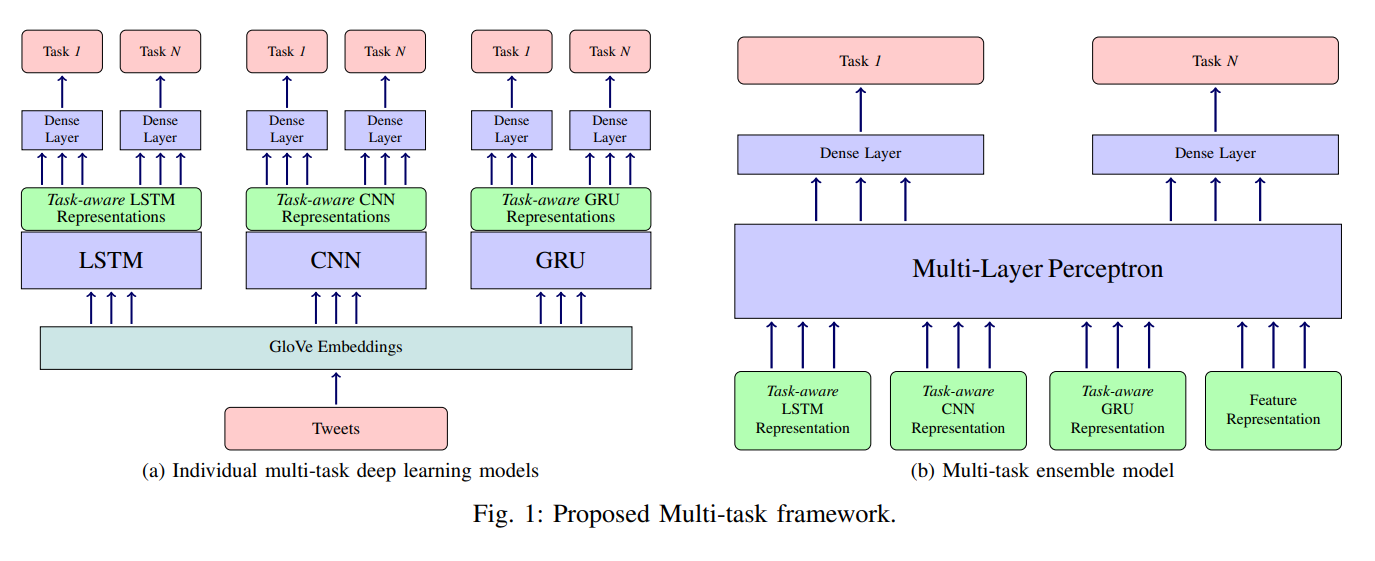

## 
# __Single Task Framework__

### LSTM

In [22]:
def LSTM_model(task):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights = [embedding_matrix], trainable=True, input_length=X_train_encoded.shape[1]))
    #model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=X_train_encoded.shape[1]))
    model.add(LSTM(128,activation='relu',return_sequences=True))
    model.add(LSTM(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(100,activation='relu'))
    
    if task == "Classification":
        model.add(Dense(4, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    elif task =="Regression":
        model.add(Dense(1,activation='sigmoid'))
        model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse',pearson_r])
    else:
        print("ERROR: INVALID TASK")
        return 
    
    return model

### GRU

In [23]:
def GRU_model(task):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights = [embedding_matrix], trainable=True, input_length=X_train_encoded.shape[1]))
    #model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=X_train_encoded.shape[1]))
    model.add(GRU(128,activation='relu',return_sequences=True))
    model.add(GRU(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(100,activation='relu'))
    
    if task == "Classification":
        model.add(Dense(4, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    elif task =="Regression":
        model.add(Dense(1,activation='sigmoid'))
        model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse',pearson_r])
    else:
        print("ERROR: INVALID TASK")
        return 
    
    return model

### CNN

In [24]:
def CNN_model(task):
    Input_layer     = Input(shape = X_train_encoded.shape[1], name="Input_layer")
    Embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_DIM,weights = [embedding_matrix],trainable=True, input_length=X_train_encoded.shape[1], name="Embedding_layer")(Input_layer)  
    #Embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=X_train_encoded.shape[1])(Input_layer)  
    CNN1_layer1     = Conv1D(100, kernel_size=2, padding="same", activation="relu")(Embedding_layer)
    CNN1_layer2     = Conv1D(100, kernel_size=3, padding="same", activation="relu")(Embedding_layer)
    CNN1_layer3     = Conv1D(100, kernel_size=4, padding="same", activation="relu")(Embedding_layer)  
    Concat_layer1   = Concatenate(axis=1)([CNN1_layer1, CNN1_layer2, CNN1_layer3])
    Pool_layer1     = MaxPooling1D(pool_size=2)(Concat_layer1)
    CNN2_layer1     = Conv1D(100, kernel_size=2, padding="same", activation="relu")(Pool_layer1)
    CNN2_layer2     = Conv1D(100, kernel_size=3, padding="same", activation="relu")(Pool_layer1)
    CNN2_layer3     = Conv1D(100, kernel_size=4, padding="same", activation="relu")(Pool_layer1)  
    Concat_layer2   = Concatenate(axis=1)([CNN2_layer1, CNN2_layer2, CNN2_layer3])
    Pool_layer2     = MaxPooling1D(pool_size=2)(Concat_layer2)    
    Flatten_layer   = Flatten()(Pool_layer2)
    Dense_layer1    = Dense(128,activation='relu', name="Dense_layer1a")(Flatten_layer)
    Dense_layer2    = Dense(100,activation='relu', name="Dense_layer1b")(Dense_layer1)
        
    if task == "Classification":
        predictions_task1 = Dense(4, activation='softmax', name="predictions_task1")(Dense_layer2)
        model= tf.keras.models.Model(Input_layer,predictions_task1)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    elif task =="Regression":
        predictions_task2 = Dense(1, activation='sigmoid', name="predictions_task2")(Dense_layer2)
        model= tf.keras.models.Model(Input_layer,predictions_task2)
        model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse',pearson_r])
    else:
        print("ERROR: INVALID TASK")
        return 
    
    return model

## Train Model and Get Accuracy

#### For Task 1

In [25]:
def getAccuracy(model, X, Y):
    history = model.fit(X,Y, epochs=40, batch_size=64,validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return history.history['accuracy'],history.history['val_accuracy']

#### For Task 2

In [26]:
def getPearsonR(model, X, Y):
    history = model.fit(X,Y, epochs=40, batch_size=64,validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    
    # summarize history for accuracy
    plt.plot(history.history['pearson_r'])
    plt.plot(history.history['val_pearson_r'])
    plt.title('Model Pearsn R Coefficient')
    plt.ylabel('pearson_r')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return history.history['pearson_r'],history.history['val_pearson_r']

## Results for Task 1

In [27]:
task1 = "Classification"
task2 = "Regression"

Results_Task1=dict()
Results_Task2=dict()

LSTM Model


Epoch 1/40
51/51 [==============================] - 13s 151ms/step - loss: 1.3648 - accuracy: 0.3257 - val_loss: 1.2762 - val_accuracy: 0.5000
Epoch 2/40
51/51 [==============================] - 8s 153ms/step - loss: 1.0689 - accuracy: 0.5699 - val_loss: 0.8867 - val_accuracy: 0.6354
Epoch 3/40
51/51 [==============================] - 9s 181ms/step - loss: 0.5958 - accuracy: 0.7911 - val_loss: 0.6783 - val_accuracy: 0.7624
Epoch 4/40
51/51 [==============================] - 9s 172ms/step - loss: 0.2796 - accuracy: 0.9069 - val_loss: 0.6353 - val_accuracy: 0.8177
Epoch 5/40
51/51 [==============================] - 9s 179ms/step - loss: 0.1578 - accuracy: 0.9466 - val_loss: 0.7948 - val_accuracy: 0.7845
Epoch 6/40
51/51 [==============================] - 8s 148ms/step - loss: 0.1065 - accuracy: 0.9691 - val_loss: 0.7838 - val_accuracy: 0.8204
Epoch 7/40
51/51 [==============================] - 9s 177ms/step - loss: 0.0803 - accuracy: 0.9704 - val_loss: 0.9554 - val_accuracy:

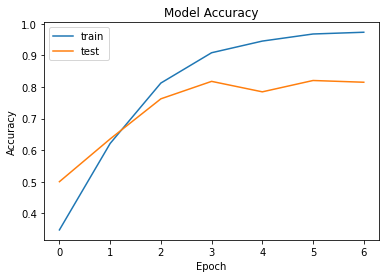

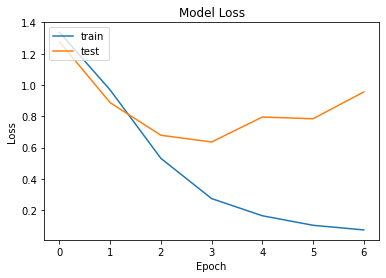

In [28]:
print("LSTM Model\n\n")
acc, val_acc = getAccuracy(LSTM_model(task1), X_train_encoded, Y1_train_encoded)
Results_Task1['LSTM']={'Accuracy':acc[-1],'Val_Accuracy':val_acc[-1]}

GRU Model


Epoch 1/40
51/51 [==============================] - 13s 146ms/step - loss: 1.3615 - accuracy: 0.3240 - val_loss: 1.1478 - val_accuracy: 0.4669
Epoch 2/40
51/51 [==============================] - 6s 119ms/step - loss: 0.9747 - accuracy: 0.5860 - val_loss: 0.7966 - val_accuracy: 0.6740
Epoch 3/40
51/51 [==============================] - 7s 145ms/step - loss: 0.4583 - accuracy: 0.8361 - val_loss: 0.6484 - val_accuracy: 0.7845
Epoch 4/40
51/51 [==============================] - 6s 122ms/step - loss: 0.1989 - accuracy: 0.9419 - val_loss: 0.7131 - val_accuracy: 0.8094
Epoch 5/40
51/51 [==============================] - 7s 138ms/step - loss: 0.1129 - accuracy: 0.9601 - val_loss: 0.8531 - val_accuracy: 0.7901
Epoch 6/40
51/51 [==============================] - 7s 137ms/step - loss: 0.0804 - accuracy: 0.9738 - val_loss: 0.8298 - val_accuracy: 0.8011


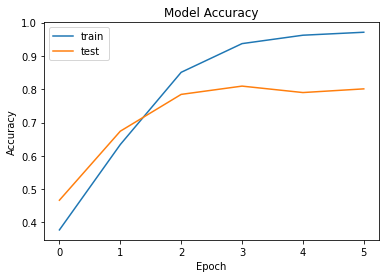

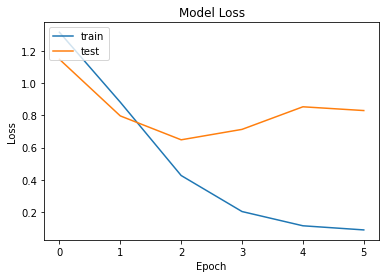

In [29]:
print("GRU Model\n\n")
acc, val_acc = getAccuracy(GRU_model(task1), X_train_encoded, Y1_train_encoded)
Results_Task1['GRU']={'Accuracy':acc[-1],'Val_Accuracy':val_acc[-1]}

CNN Model


Epoch 1/40
51/51 [==============================] - 7s 116ms/step - loss: 1.3452 - accuracy: 0.3359 - val_loss: 1.0896 - val_accuracy: 0.5359
Epoch 2/40
51/51 [==============================] - 5s 101ms/step - loss: 0.7011 - accuracy: 0.7443 - val_loss: 0.8332 - val_accuracy: 0.7072
Epoch 3/40
51/51 [==============================] - 5s 93ms/step - loss: 0.1810 - accuracy: 0.9533 - val_loss: 0.7899 - val_accuracy: 0.7431
Epoch 4/40
51/51 [==============================] - 5s 99ms/step - loss: 0.0944 - accuracy: 0.9776 - val_loss: 0.8637 - val_accuracy: 0.7597
Epoch 5/40
51/51 [==============================] - 5s 103ms/step - loss: 0.0537 - accuracy: 0.9847 - val_loss: 0.8997 - val_accuracy: 0.7707
Epoch 6/40
51/51 [==============================] - 5s 98ms/step - loss: 0.0349 - accuracy: 0.9897 - val_loss: 0.8250 - val_accuracy: 0.7901


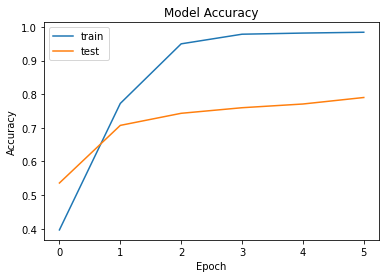

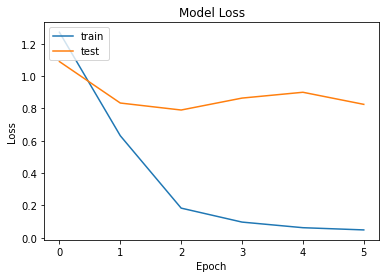

In [30]:
print("CNN Model\n\n")
acc, val_acc = getAccuracy(CNN_model(task1), X_train_encoded, Y1_train_encoded)
Results_Task1['CNN']={'Accuracy':acc[-1],'Val_Accuracy':val_acc[-1]}

### Defining Pearsons Correlation Coefficient for Task 2

In [60]:
from keras import backend as K
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

## Results for Task 2

LSTM Model


Epoch 1/40
51/51 [==============================] - 17s 214ms/step - loss: 0.1507 - mse: 0.0351 - pearson_r: 0.1269 - val_loss: 0.1491 - val_mse: 0.0331 - val_pearson_r: 0.2817
Epoch 2/40
51/51 [==============================] - 12s 232ms/step - loss: 0.1416 - mse: 0.0314 - pearson_r: 0.4211 - val_loss: 0.1427 - val_mse: 0.0314 - val_pearson_r: 0.3468
Epoch 3/40
51/51 [==============================] - 10s 201ms/step - loss: 0.1170 - mse: 0.0235 - pearson_r: 0.5855 - val_loss: 0.1390 - val_mse: 0.0315 - val_pearson_r: 0.3875
Epoch 4/40
51/51 [==============================] - 10s 194ms/step - loss: 0.1031 - mse: 0.0188 - pearson_r: 0.7021 - val_loss: 0.1386 - val_mse: 0.0315 - val_pearson_r: 0.4140
Epoch 5/40
51/51 [==============================] - 11s 225ms/step - loss: 0.0847 - mse: 0.0137 - pearson_r: 0.7984 - val_loss: 0.1393 - val_mse: 0.0325 - val_pearson_r: 0.4209
Epoch 6/40
51/51 [==============================] - 10s 188ms/step - loss: 0.0800 - mse: 0.0117 - pear

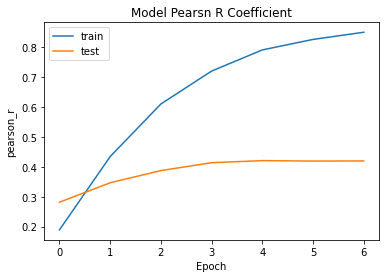

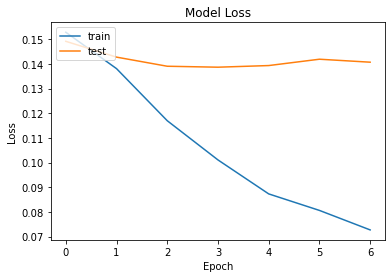

In [32]:
print("LSTM Model\n\n")
pearson_r, val_pearson_r = getPearsonR(LSTM_model(task2), X_train_encoded, Y2_train_encoded)
Results_Task2['LSTM']={'pearson_r':pearson_r[-1],'Val_pearson_r':val_pearson_r[-1]}

GRU Model


Epoch 1/40
51/51 [==============================] - 10s 134ms/step - loss: 0.1590 - mse: 0.0379 - pearson_r: 0.0415 - val_loss: 0.1525 - val_mse: 0.0344 - val_pearson_r: 0.2305
Epoch 2/40
51/51 [==============================] - 5s 95ms/step - loss: 0.1440 - mse: 0.0325 - pearson_r: 0.3746 - val_loss: 0.1495 - val_mse: 0.0345 - val_pearson_r: 0.2996
Epoch 3/40
51/51 [==============================] - 7s 140ms/step - loss: 0.1228 - mse: 0.0255 - pearson_r: 0.5626 - val_loss: 0.1439 - val_mse: 0.0320 - val_pearson_r: 0.3345
Epoch 4/40
51/51 [==============================] - 8s 151ms/step - loss: 0.1034 - mse: 0.0190 - pearson_r: 0.6921 - val_loss: 0.1439 - val_mse: 0.0336 - val_pearson_r: 0.3329
Epoch 5/40
51/51 [==============================] - 8s 158ms/step - loss: 0.0888 - mse: 0.0149 - pearson_r: 0.7860 - val_loss: 0.1392 - val_mse: 0.0315 - val_pearson_r: 0.3706
Epoch 6/40
51/51 [==============================] - 5s 106ms/step - loss: 0.0785 - mse: 0.0117 - pearson_r: 

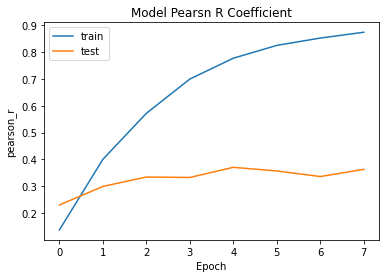

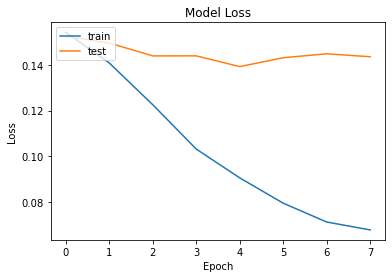

In [58]:
print("GRU Model\n\n")
pearson_r, val_pearson_r = getPearsonR(GRU_model(task2), X_train_encoded, Y2_train_encoded)
Results_Task2['GRU']={'pearson_r':pearson_r[-1],'Val_pearson_r':val_pearson_r[-1]}

CNN Model


Epoch 1/40
51/51 [==============================] - 8s 116ms/step - loss: 0.1667 - mse: 0.0422 - pearson_r: 0.1137 - val_loss: 0.1475 - val_mse: 0.0323 - val_pearson_r: 0.3225
Epoch 2/40
51/51 [==============================] - 5s 103ms/step - loss: 0.1303 - mse: 0.0270 - pearson_r: 0.5477 - val_loss: 0.1434 - val_mse: 0.0317 - val_pearson_r: 0.3603
Epoch 3/40
51/51 [==============================] - 5s 90ms/step - loss: 0.0987 - mse: 0.0163 - pearson_r: 0.7581 - val_loss: 0.1442 - val_mse: 0.0319 - val_pearson_r: 0.3365
Epoch 4/40
51/51 [==============================] - 5s 101ms/step - loss: 0.0877 - mse: 0.0133 - pearson_r: 0.8197 - val_loss: 0.1463 - val_mse: 0.0342 - val_pearson_r: 0.4148
Epoch 5/40
51/51 [==============================] - 5s 100ms/step - loss: 0.0731 - mse: 0.0097 - pearson_r: 0.8615 - val_loss: 0.1399 - val_mse: 0.0314 - val_pearson_r: 0.4136
Epoch 6/40
51/51 [==============================] - 4s 81ms/step - loss: 0.0677 - mse: 0.0084 - pearson_r: 0.

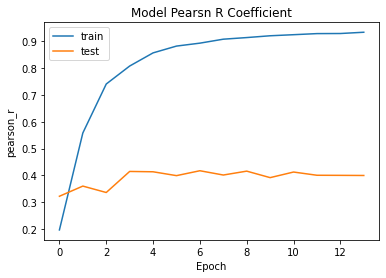

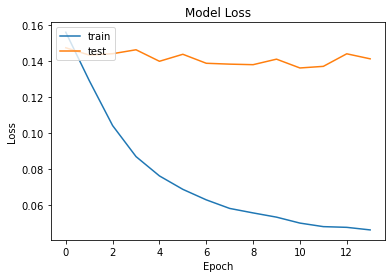

In [61]:
print("CNN Model\n\n")
pearson_r, val_pearson_r = getPearsonR(CNN_model(task2), X_train_encoded, Y2_train_encoded)
Results_Task2['CNN']={'pearson_r':pearson_r[-1],'Val_pearson_r':val_pearson_r[-1]}

## Performance Comparision

### Task 1

In [62]:
print("Single Task Framework - Task 1 Results\n")
# Print the names of the column
print ("{:<10} {:<15} {:<10}".format('Model', 'Train Accuracy', ' Test Accuracy'))
  
# print each data item.
for key, value in Results_Task1.items():
    train_acc = round(value['Accuracy'],3)
    val_acc   = round(value['Val_Accuracy'],3)
    print ("{:<10} {:<17} {:<10}".format(key, train_acc, val_acc))

Single Task Framework - Task 1 Results

Model      Train Accuracy   Test Accuracy
LSTM       0.973             0.815     
GRU        0.971             0.801     
CNN        0.984             0.79      


### Task 2

In [63]:
print("Single Task Framework - Task 2 Results\n")
# Print the names of the column
print ("{:<10} {:<15} {:<10}".format('Model', 'Train pearson_r', ' Val pearson_r'))
  
# print each data item.
for key, value in Results_Task2.items():
    train_acc = round(value['pearson_r'],3)
    val_acc   = round(value['Val_pearson_r'],3)
    print ("{:<10} {:<17} {:<10}".format(key, train_acc, val_acc))

Single Task Framework - Task 2 Results

Model      Train pearson_r  Val pearson_r
LSTM       0.851             0.42      
GRU        0.873             0.363     
CNN        0.933             0.4       


# 
# __Multi-tasking Framework__

In [144]:
Multitask_Results_Task1 = {}
Multitask_Results_Task2 = {}
alpha = 0.185

In [145]:
from keras import backend as K
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

## __Multi-tasking LSTM Model__

### Create Model

In [146]:
def create_multihead_LSTM_model(X):
    #Shared Layers
    Input_layer       = Input(shape = X.shape[1], name="Input_layer")
    Embedding_layer   = Embedding(VOCAB_SIZE, EMBEDDING_DIM,weights = [embedding_matrix], trainable=True, input_length=X.shape[1], name="Embedding_layer")(Input_layer)    
    #Embedding_layer  = Embedding(VOCAB_SIZE,EMBEDDING_DIM, input_length=X.shape[1], name="Embedding_layer")(Input_layer)    
    LSTM_layer1       = LSTM(128,activation='relu', return_sequences=True, name="LSTM_layer1" )(Embedding_layer)
    LSTM_layer2       = LSTM(128,activation='relu', name="LSTM_layer2")(LSTM_layer1)
    Dropout_layer     = Dropout(0.25, name="Dropout_layer")(LSTM_layer2)
    
    #Task Specific Layer for Task 1
    Dense_layer1a     = Dense(128,activation='relu', name="Dense_layer1a")(Dropout_layer)
    Dense_layer1b     = Dense(100,activation='relu', name="Dense_layer1b")(Dense_layer1a)
        
    #Task Specific Layer for Task 2
    Dense_layer2a     = Dense(128,activation='relu', name="Dense_layer2a")(Dropout_layer)
    Dense_layer2b     = Dense(100,activation='relu', name="Dense_layer2b")(Dense_layer2a)
    
    # Predictions for each task
    predictions_task1 = Dense(4, activation='softmax', name="predictions_task1")(Dense_layer1b)
    predictions_task2 = Dense(1, name="predictions_task2")(Dense_layer2b)
    
    model= tf.keras.models.Model(Input_layer, [predictions_task1,predictions_task2])
    model.compile( loss= {'predictions_task1':'categorical_crossentropy' , 'predictions_task2':'mean_absolute_error' },
                   loss_weights=[alpha,1-alpha],
                   optimizer='adam',
                   metrics={'predictions_task1':'accuracy' , 'predictions_task2':pearson_r }, 
                 )
    return model

In [147]:
Multihead_LSTM_model = create_multihead_LSTM_model(X_train_encoded)

### Train Model

In [148]:
Multihead_LSTM_model_history = Multihead_LSTM_model.fit(X_train_encoded, [Y1_train_encoded,Y2_train_encoded], epochs=40, batch_size=64,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])    

Epoch 1/40
51/51 [==============================] - 20s 278ms/step - loss: 0.4333 - predictions_task1_loss: 1.3784 - predictions_task2_loss: 0.2188 - predictions_task1_accuracy: 0.2899 - predictions_task2_pearson_r: 0.0675 - val_loss: 0.3749 - val_predictions_task1_loss: 1.3732 - val_predictions_task2_loss: 0.1483 - val_predictions_task1_accuracy: 0.2790 - val_predictions_task2_pearson_r: 0.2921
Epoch 2/40
51/51 [==============================] - 13s 264ms/step - loss: 0.3609 - predictions_task1_loss: 1.3305 - predictions_task2_loss: 0.1408 - predictions_task1_accuracy: 0.3510 - predictions_task2_pearson_r: 0.3742 - val_loss: 0.3441 - val_predictions_task1_loss: 1.1651 - val_predictions_task2_loss: 0.1578 - val_predictions_task1_accuracy: 0.4006 - val_predictions_task2_pearson_r: 0.3715
Epoch 3/40
51/51 [==============================] - 13s 261ms/step - loss: 0.3063 - predictions_task1_loss: 1.0847 - predictions_task2_loss: 0.1297 - predictions_task1_accuracy: 0.4967 - predictions_tas

### Summarize Model Results

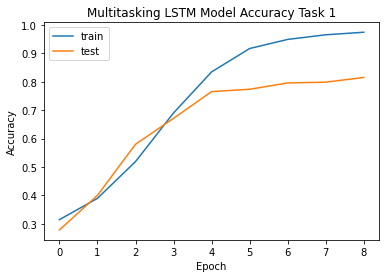

In [149]:
# Summarize history for Task 1
plt.plot(Multihead_LSTM_model_history.history['predictions_task1_accuracy'])
plt.plot(Multihead_LSTM_model_history.history['val_predictions_task1_accuracy'])
plt.title('Multitasking LSTM Model Accuracy Task 1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

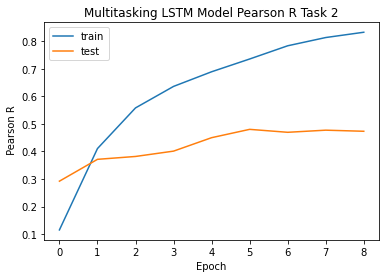

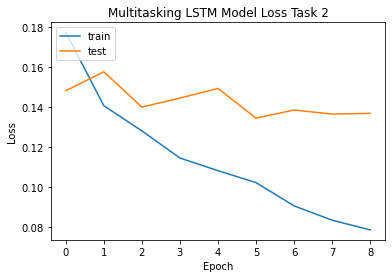

In [150]:
# Summarize history for Task 2
plt.plot(Multihead_LSTM_model_history.history['predictions_task2_pearson_r'])
plt.plot(Multihead_LSTM_model_history.history['val_predictions_task2_pearson_r'])
plt.title('Multitasking LSTM Model Pearson R Task 2')
plt.ylabel(' Pearson R')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for Task 2
plt.plot(Multihead_LSTM_model_history.history['predictions_task2_loss'])
plt.plot(Multihead_LSTM_model_history.history['val_predictions_task2_loss'])
plt.title('Multitasking LSTM Model Loss Task 2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [151]:
Multitask_Results_Task1['LSTM'] ={'Accuracy':Multihead_LSTM_model_history.history['predictions_task1_accuracy'][-1],
                                  'Val_Accuracy':Multihead_LSTM_model_history.history['val_predictions_task1_accuracy'][-1]
                                 }
Multitask_Results_Task2['LSTM'] ={'pearson_r':Multihead_LSTM_model_history.history['predictions_task2_pearson_r'][-1],
                                  'Val_pearson_r':Multihead_LSTM_model_history.history['val_predictions_task2_pearson_r'][-1]}

### Plotting Model Architecture

## __Multi-tasking GRU Model__

### Create Model

In [152]:
def create_multihead_GRU_model(X):
    #Shared Layers
    Input_layer       = Input(shape = X.shape[1], name="Input_layer")
    Embedding_layer   = Embedding(VOCAB_SIZE, EMBEDDING_DIM,weights = [embedding_matrix], trainable=True, input_length=X.shape[1], name="Embedding_layer")(Input_layer)    
    #Embedding_layer   = Embedding(VOCAB_SIZE,EMBEDDING_DIM, input_length=X.shape[1], name="Embedding_layer")(Input_layer)    
    GRU_layer1        = GRU(128,activation='relu', return_sequences=True, name="GRU_layer1" )(Embedding_layer)
    GRU_layer2        = GRU(128,activation='relu', name="GRU_layer2")(GRU_layer1)
    Dropout_layer     = Dropout(0.25, name="Dropout_layer")(GRU_layer2)
    
    #Task Specific Layer for Task 1
    Dense_layer1a     = Dense(128,activation='relu', name="Dense_layer1a")(Dropout_layer)
    Dense_layer1b     = Dense(100,activation='relu', name="Dense_layer1b")(Dense_layer1a)
        
    #Task Specific Layer for Task 2
    Dense_layer2a     = Dense(128,activation='relu', name="Dense_layer2a")(Dropout_layer)
    Dense_layer2b     = Dense(100,activation='relu', name="Dense_layer2b")(Dense_layer2a)
    
    # Predictions for each task
    predictions_task1 = Dense(4, activation='softmax', name="predictions_task1")(Dense_layer1b)
    predictions_task2 = Dense(1, activation='sigmoid', name="predictions_task2")(Dense_layer2b)
    
    model= tf.keras.models.Model(Input_layer, [predictions_task1,predictions_task2])
    model.compile( loss= {'predictions_task1':'categorical_crossentropy' , 'predictions_task2':'mean_absolute_error' },
                   loss_weights=[alpha,1-alpha],
                   optimizer='adam',
                   metrics={'predictions_task1':'accuracy' , 'predictions_task2':pearson_r },  
                 )
    return model

In [153]:
Multihead_GRU_model = create_multihead_GRU_model(X_train_encoded)

### Train Model

In [154]:
Multihead_GRU_model_history = Multihead_GRU_model.fit(X_train_encoded, [Y1_train_encoded,Y2_train_encoded], epochs=40, batch_size=64,validation_split=0.1,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/40
51/51 [==============================] - 15s 209ms/step - loss: 0.3796 - predictions_task1_loss: 1.3707 - predictions_task2_loss: 0.1547 - predictions_task1_accuracy: 0.2905 - predictions_task2_pearson_r: 0.1121 - val_loss: 0.3543 - val_predictions_task1_loss: 1.2555 - val_predictions_task2_loss: 0.1497 - val_predictions_task1_accuracy: 0.4227 - val_predictions_task2_pearson_r: 0.2470
Epoch 2/40
51/51 [==============================] - 7s 141ms/step - loss: 0.3243 - predictions_task1_loss: 1.1246 - predictions_task2_loss: 0.1426 - predictions_task1_accuracy: 0.4962 - predictions_task2_pearson_r: 0.3806 - val_loss: 0.2928 - val_predictions_task1_loss: 0.9266 - val_predictions_task2_loss: 0.1489 - val_predictions_task1_accuracy: 0.5967 - val_predictions_task2_pearson_r: 0.3082
Epoch 3/40
51/51 [==============================] - 6s 120ms/step - loss: 0.2208 - predictions_task1_loss: 0.6331 - predictions_task2_loss: 0.1273 - predictions_task1_accuracy: 0.7620 - predictions_task2

### Summarize Model Accuracy

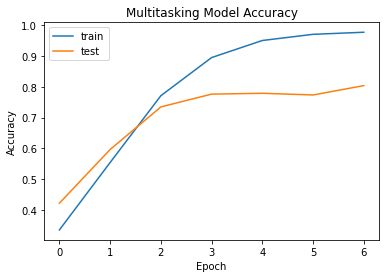

In [155]:
# Summarize history for Task 1
plt.plot(Multihead_GRU_model_history.history['predictions_task1_accuracy'])
plt.plot(Multihead_GRU_model_history.history['val_predictions_task1_accuracy'])
plt.title('Multitasking Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

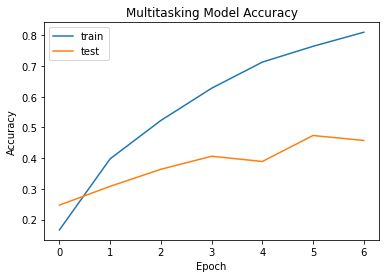

In [156]:
# Summarize history for Task 2
plt.plot(Multihead_GRU_model_history.history['predictions_task2_pearson_r'])
plt.plot(Multihead_GRU_model_history.history['val_predictions_task2_pearson_r'])
plt.title('Multitasking Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [157]:
Multitask_Results_Task1['GRU'] ={'Accuracy':Multihead_GRU_model_history.history['predictions_task1_accuracy'][-1],
                                  'Val_Accuracy':Multihead_GRU_model_history.history['val_predictions_task1_accuracy'][-1]}
Multitask_Results_Task2['GRU'] ={'pearson_r':Multihead_GRU_model_history.history['predictions_task2_pearson_r'][-1],
                                  'Val_pearson_r':Multihead_GRU_model_history.history['val_predictions_task2_pearson_r'][-1]}

### Plotting Model Architecture

## __Multi-tasking CNN Model__

### Create Model

In [158]:
def create_multihead_CNN_model(X):
    #Shared Layers
    Input_layer       = Input(shape = X.shape[1], name="Input_layer")
    Embedding_layer   = Embedding(VOCAB_SIZE, EMBEDDING_DIM,weights = [embedding_matrix], trainable=True, input_length=X.shape[1], name="Embedding_layer")(Input_layer)    
    #Embedding_layer  = Embedding(VOCAB_SIZE,EMBEDDING_DIM, input_length=X.shape[1], name="Embedding_layer")(Input_layer)    
    CNN1_layer1       = Conv1D(100, kernel_size=2, padding="same", activation="relu")(Embedding_layer)
    CNN1_layer2       = Conv1D(100, kernel_size=3, padding="same", activation="relu")(Embedding_layer)
    CNN1_layer3       = Conv1D(100, kernel_size=4, padding="same", activation="relu")(Embedding_layer)  
    Concat_layer1     = Concatenate(axis=1)([CNN1_layer1, CNN1_layer2, CNN1_layer3])
    Pool_layer1       = MaxPooling1D(pool_size=2)(Concat_layer1)
    CNN2_layer1       = Conv1D(100, kernel_size=2, padding="same", activation="relu")(Pool_layer1)
    CNN2_layer2       = Conv1D(100, kernel_size=3, padding="same", activation="relu")(Pool_layer1)
    CNN2_layer3       = Conv1D(100, kernel_size=4, padding="same", activation="relu")(Pool_layer1)  
    Concat_layer2     = Concatenate(axis=1)([CNN2_layer1, CNN2_layer2, CNN2_layer3])
    Pool_layer2       = MaxPooling1D(pool_size=2)(Concat_layer2)    
    Flatten_layer     = Flatten()(Pool_layer2)
    
    #Task Specific Layer for Task 1
    Dense_layer1a     = Dense(128,activation='relu', name="Dense_layer1a")(Flatten_layer)
    Dense_layer1b     = Dense(100,activation='relu', name="Dense_layer1b")(Dense_layer1a)
        
    #Task Specific Layer for Task 2
    Dense_layer2a     = Dense(128,activation='relu', name="Dense_layer2a")(Flatten_layer)
    Dense_layer2b     = Dense(100,activation='relu', name="Dense_layer2b")(Dense_layer2a)
    
    # Predictions for each task
    predictions_task1 = Dense(4, activation='softmax', name="predictions_task1")(Dense_layer1b)
    predictions_task2 = Dense(1, activation='sigmoid', name="predictions_task2")(Dense_layer2b)
    
    model= tf.keras.models.Model(Input_layer, [predictions_task1,predictions_task2])
    model.compile( loss= {'predictions_task1':'categorical_crossentropy' , 'predictions_task2':'mean_absolute_error' },
                   optimizer='adam', 
                   loss_weights=[alpha,1-alpha],
                   metrics={'predictions_task1':'accuracy' , 'predictions_task2':pearson_r },  
                 )
    return model

In [159]:
Multihead_CNN_model = create_multihead_CNN_model(X_train_encoded)

In [160]:
Multihead_CNN_model_history = Multihead_CNN_model.fit(X_train_encoded, [Y1_train_encoded,Y2_train_encoded], epochs=40, batch_size=64,validation_split=0.1,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/40
51/51 [==============================] - 10s 137ms/step - loss: 0.3852 - predictions_task1_loss: 1.3692 - predictions_task2_loss: 0.1618 - predictions_task1_accuracy: 0.3367 - predictions_task2_pearson_r: 0.0989 - val_loss: 0.3449 - val_predictions_task1_loss: 1.1998 - val_predictions_task2_loss: 0.1508 - val_predictions_task1_accuracy: 0.4503 - val_predictions_task2_pearson_r: 0.2609
Epoch 2/40
51/51 [==============================] - 6s 122ms/step - loss: 0.2751 - predictions_task1_loss: 0.8861 - predictions_task2_loss: 0.1364 - predictions_task1_accuracy: 0.6405 - predictions_task2_pearson_r: 0.5084 - val_loss: 0.2665 - val_predictions_task1_loss: 0.7973 - val_predictions_task2_loss: 0.1460 - val_predictions_task1_accuracy: 0.6934 - val_predictions_task2_pearson_r: 0.3047
Epoch 3/40
51/51 [==============================] - 6s 119ms/step - loss: 0.1364 - predictions_task1_loss: 0.2482 - predictions_task2_loss: 0.1111 - predictions_task1_accuracy: 0.9343 - predictions_task2

### Summarize Model Accuracy

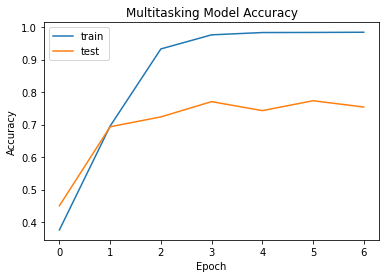

In [161]:
# Summarize history for Task 1
plt.plot(Multihead_CNN_model_history.history['predictions_task1_accuracy'])
plt.plot(Multihead_CNN_model_history.history['val_predictions_task1_accuracy'])
plt.title('Multitasking Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

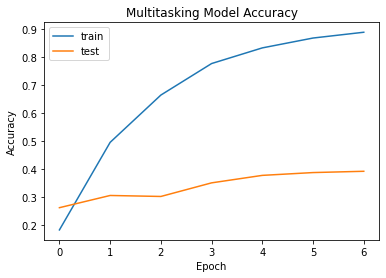

In [162]:
# Summarize history for Task 2
plt.plot(Multihead_CNN_model_history.history['predictions_task2_pearson_r'])
plt.plot(Multihead_CNN_model_history.history['val_predictions_task2_pearson_r'])
plt.title('Multitasking Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [163]:
Multitask_Results_Task1['CNN'] ={'Accuracy':Multihead_CNN_model_history.history['predictions_task1_accuracy'][-1],
                                  'Val_Accuracy':Multihead_CNN_model_history.history['val_predictions_task1_accuracy'][-1]}
Multitask_Results_Task2['CNN'] ={'pearson_r':Multihead_CNN_model_history.history['predictions_task2_pearson_r'][-1],
                                  'Val_pearson_r':Multihead_CNN_model_history.history['val_predictions_task2_pearson_r'][-1]}

### Plotting Model Architecture

## Performance Comparision

### Task 1

In [164]:
print("Multitasking Framework Task 1 Results\n")
# Print the names of the column
print ("{:<10} {:<15} {:<10}".format('Model', 'Train Accuracy', ' Val Accuracy'))
  
# print each data item.
for key, value in Multitask_Results_Task1.items():
    train_acc = round(value['Accuracy'],3)
    val_acc   = round(value['Val_Accuracy'],3)
    print ("{:<10} {:<17} {:<10}".format(key, train_acc, val_acc))

Multitasking Framework Task 1 Results

Model      Train Accuracy   Val Accuracy
LSTM       0.974             0.815     
GRU        0.977             0.804     
CNN        0.984             0.754     


### Task 2

In [165]:
print("Multitasking Framework Task 2 Results\n")
# Print the names of the column
print ("{:<10} {:<15} {:<10}".format('Model', 'Train Pearson_R', ' Val Pearson_R'))
  
# print each data item.
for key, value in Multitask_Results_Task2.items():
    train_acc = round(value['pearson_r'],3)
    val_acc   = round(value['Val_pearson_r'],3)
    print ("{:<10} {:<17} {:<10}".format(key, train_acc, val_acc))

Multitasking Framework Task 2 Results

Model      Train Pearson_R  Val Pearson_R
LSTM       0.833             0.474     
GRU        0.81              0.458     
CNN        0.89              0.391     


# __Performance Comparision : Single Task Vs Multi Task Framework__

### Task 1

In [166]:
print("Performance Comparision : Single Task Vs Multi Task Framework\n\n")
# Print the names of the column

print ("{:<20} {:<30} {:<20}".format('Framework','Single Task', 'Multi Task'))
print ("{:<10} {:<15} {:<10} {:<15} {:<10}".format('Model', 'Train Accuracy', ' Val Accuracy  ','  Train Accuracy', ' Val Accuracy'))
  
# print each data item.
for key in ['LSTM','GRU','CNN']:
    train_acc1 = round(Results_Task1[key]['Accuracy'],3)
    val_acc1   = round(Results_Task1[key]['Val_Accuracy'],3)
    train_acc2 = round(Multitask_Results_Task1[key]['Accuracy'],3)
    val_acc2   = round(Multitask_Results_Task1[key]['Val_Accuracy'],3)
    print ("{:<10} {:<17} {:<20} {:<17} {:<10}".format(key, train_acc1, val_acc1,train_acc2, val_acc2))

Performance Comparision : Single Task Vs Multi Task Framework


Framework            Single Task                    Multi Task          
Model      Train Accuracy   Val Accuracy     Train Accuracy  Val Accuracy
LSTM       0.973             0.815                0.974             0.815     
GRU        0.971             0.801                0.977             0.804     
CNN        0.984             0.79                 0.984             0.754     


### Task 2

In [167]:
print("Performance Comparision : Single Task Vs Multi Task Framework\n\n")
# Print the names of the column

print ("{:<20} {:<30} {:<20}".format('Framework','Single Task', 'Multi Task'))
print ("{:<10} {:<15} {:<10} {:<15} {:<10}".format('Model', 'Train pearson_r', ' Val pearson_r  ','  Train pearson_r', ' Val pearson_r'))
  
# print each data item.
for key in ['LSTM','GRU','CNN']:
    train_acc1 = round(Results_Task2[key]['pearson_r'],3)
    val_acc1   = round(Results_Task2[key]['Val_pearson_r'],3)
    train_acc2 = round(Multitask_Results_Task2[key]['pearson_r'],3)
    val_acc2   = round(Multitask_Results_Task2[key]['Val_pearson_r'],3)
    print ("{:<10} {:<17} {:<20} {:<17} {:<10}".format(key, train_acc1, val_acc1,train_acc2, val_acc2))

Performance Comparision : Single Task Vs Multi Task Framework


Framework            Single Task                    Multi Task          
Model      Train pearson_r  Val pearson_r     Train pearson_r  Val pearson_r
LSTM       0.851             0.42                 0.833             0.474     
GRU        0.873             0.363                0.81              0.458     
CNN        0.933             0.4                  0.89              0.391     


# __Ensemble Framework__

## Task-aware Representations

In [ ]:
Task1_aware_LSTM_Representation = Multihead_LSTM_model.get_layer("Dense_layer1b")
Task2_aware_LSTM_Representation = Multihead_LSTM_model.get_layer("Dense_layer2b")

Task1_aware_GRU_Representation = Multihead_GRU_model.get_layer("Dense_layer1b")
Task2_aware_GRU_Representation = Multihead_GRU_model.get_layer("Dense_layer2b")

Task1_aware_CNN_Representation = Multihead_CNN_model.get_layer("Dense_layer1b")
Task2_aware_CNN_Representation = Multihead_CNN_model.get_layer("Dense_layer2b")

These three task-aware deep representations are concatenated with a feature vector before feeding into the multi-task ensemble model. The multi-task ensemble model is a MLP network which comprises of four hidden layers. The first two hidden layers are shared for all the tasks (the hidden representation jointly captures the relationship of all the input representations) and the final two hidden layers are specific for each individual task to learn the mapping of the shared hidden representation and output labels. The idea is to exploit the richness of different feature representations and to learn a combined representation for solving multiple tasks

In [ ]:
def create_ensemble_model(Task_aware_Representations):
    #Shared Layers
    Concat_layer    = Concatenate(axis=1)(Task_aware_Representations)
    Dense_layer1    = Dense(128,activation='relu', name="Dense_layer1")(Concat_layer)
    Dense_layer2    = Dense(128,activation='relu', name="Dense_layer2")(Dense_layer1)
        
    #Task Specific Layer for Task 1
    Dense_layer_task1 = Dense(128,activation='relu', name="Dense_layer_task1")(Dense_layer2)
    predictions_task1 = Dense(4, activation='softmax', name="predictions_task1")(Dense_layer_task1)
    
    #Task Specific Layer for Task 1
    Dense_layer_task2 = Dense(128,activation='relu', name="Dense_layer_task2")(Dense_layer2)
    predictions_task2 = Dense(1, activation='sigmoid', name="predictions_task2")(Dense_layer_task2)
    
    model= tf.keras.models.Model(Input_layer, [predictions_task1,predictions_task2])
    model.compile( loss= {'predictions_task1':'categorical_crossentropy' , 'predictions_task2':'mean_absolute_error' },
                   optimizer='adam',
                   metrics={'predictions_task1':'accuracy' , 'predictions_task2':pearson_r },  
               )
    return model

In [ ]:
Multihead_Ensemble_model = create_ensemble_model(Task_aware_Representations)